# Our Goal

Our model is designed to compute:

$x_{t+1}$ from $x_t$

So we can directly predict the next state of our system given the current state.

Unlike the base model, we will use a single set of fixed parameters for the entire dataset, rather than generating new parameters for each datapoint.

# Our Data

Our model receives:
- $x_t$: Current state

And attempts to predict:
- $x_{t+1}$: The next state

We generate our data by:
- First establishing fixed physical parameters for the entire dataset
- Then for each datapoint:
  - Generating a new, random initial state $x_t$
  - Running it forward one timestep to get $x_{t+1}$
  - Using this pair to create one datapoint
  - Repeat with new random initial states but same fixed parameters

# Imports

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Dict, Tuple, List
import helper
import matplotlib.pyplot as plt
import os
import h5py
from tqdm import tqdm

# Class for generating data

In [23]:
class StateModelDataset(Dataset):
    def __init__(self, num_runs: int, timesteps_per_run: int, nr: int, nc: int, dt: float, F: float, fixed_params: dict = None):
        """
        Initialize dataset with fixed parameters for all samples.
        
        Args:
            num_runs (int): Number of different world configurations to generate
            timesteps_per_run (int): Number of timesteps to simulate for each world
            nr (int): Number of rows in grid
            nc (int): Number of columns in grid
            dt (float): Time step size
            F (float): Forcing parameter
            fixed_params (dict): Optional pre-generated parameters to use instead of generating new ones
        """
        self.num_runs = num_runs
        self.timesteps_per_run = timesteps_per_run
        self.nr = nr
        self.nc = nc
        self.dt = dt
        self.F = F
        
        # Either use provided parameters or generate new ones
        self.fixed_params = fixed_params if fixed_params is not None else self._generate_params()
        self.samples = self._generate_samples()

    def _generate_gaussian_field(self, n, nrv, ncv):
        """
        Generate a Gaussian field composed of n Gaussian functions.
        Uses same parameters as helper.py for consistency.
        """
        mux = np.random.choice(ncv, n)
        muy = np.random.choice(range(2, nrv - 2), n)
        sigmax = np.random.uniform(1, ncv/4, n)
        sigmay = np.random.uniform(1, nrv/4, n)

        v = np.zeros((nrv, ncv))
        for i in range(n):
            for x in range(ncv):
                for y in range(nrv):
                    # Create three copies for pseudo-periodic field
                    gauss = np.exp(-((x-mux[i])**2/(2*sigmax[i]**2) + (y-muy[i])**2/(2*sigmay[i]**2)))
                    gauss += np.exp(-((x-(mux[i]-ncv))**2/(2*sigmax[i]**2) + (y-muy[i])**2/(2*sigmay[i]**2)))
                    gauss += np.exp(-((x-(mux[i]+ncv))**2/(2*sigmax[i]**2) + (y-muy[i])**2/(2*sigmay[i]**2)))
                    v[y,x] += gauss
        return v

    def _generate_circular_field(self, v):
        """Generate a circular field from gradient of input field."""
        grad_v_y, grad_v_x = np.gradient(v)
        return -grad_v_y, grad_v_x

    def _generate_params(self):
        """
        Generate fixed model parameters to be used for all samples.
        Modified to match helper.py parameter generation.
        """
        # Base grid parameters - unit spacing
        DX_C = torch.ones(self.nr, self.nc + 1)
        DY_C = torch.ones(self.nr + 1, self.nc)
        DX_G = torch.ones(self.nr + 1, self.nc)
        DY_G = torch.ones(self.nr, self.nc + 1)
        RAC = torch.ones(self.nr, self.nc)

        # Generate random diffusivities (must be positive)
        # Using random uniform distribution between 0 and 1
        KX = torch.rand(self.nr, self.nc + 1)
        KY = torch.rand(self.nr + 1, self.nc)

        # Generate velocities using Gaussian field approach
        num_gauss = 8  # Number of Gaussian functions for velocity field
        gauss = self._generate_gaussian_field(num_gauss, self.nr + 1, self.nc + 1)
        VX_np, VY_np = self._generate_circular_field(gauss)
        
        # Convert velocities to PyTorch and scale
        # Using scaling factor of 100 as in helper.py
        VX = torch.from_numpy(100 * VX_np[:-1, :]).float()
        VY = torch.from_numpy(100 * VY_np[:, :-1]).float()

        # Generate random forcing field with controlled magnitude
        # Using standard normal distribution scaled down
        cov_C = helper.compute_covariance_matrix_gaussian_dropoff(nr = self.nr, nc = self.nc, std_dev = 1.5)
        f = helper.generate_random_vector_mean_0_cov_C( nr = self.nr, nc = self.nc, C = cov_C )[1]
        
        # Torchify and scale
        f = torch.from_numpy(1 * f).float().reshape(-1)
        #print(f.shape)

        return {
            'KX': KX,
            'KY': KY,
            'DX_C': DX_C,
            'DY_C': DY_C,
            'DX_G': DX_G,
            'DY_G': DY_G,
            'VX': VX,
            'VY': VY,
            'RAC': RAC,
            'f': f,
        }

    def _generate_samples(self):
        """Generate multiple samples using fixed parameters but with controlled initial states."""
        samples = []
        total_samples = self.num_runs * (self.timesteps_per_run - 1)  # -1 because we need pairs

        cov_C = helper.compute_covariance_matrix_gaussian_dropoff(nr = self.nr, nc = self.nc, std_dev = 1.5)
        
        for run in range(self.num_runs):
            if run % 100 == 0:
                print(f"Generating world {run+1}/{self.num_runs}")
            
            # Generate initial state with controlled magnitude
            # Scale by 1/sqrt(n) to maintain reasonable magnitudes
            x_current = helper.generate_random_vector_mean_0_cov_C( nr = self.nr, nc = self.nc, C = cov_C )[1]
            
            # Torchify and scale
            x_current = torch.from_numpy(1 * x_current).float().reshape(-1)
            #print(x_current.shape)
            
            # Generate timesteps for this world
            world_states = [x_current]
            for t in range(self.timesteps_per_run - 1):
                x_next = self._compute_next_state(x_current)
                world_states.append(x_next)
                x_current = x_next
            
            # Create pairs of consecutive states as samples
            for t in range(len(world_states) - 1):
                samples.append((world_states[t], world_states[t + 1]))
        
        return samples

    def _compute_next_state(self, x_t):
        """Compute x(t+1) using fixed parameters."""
        # Convert PyTorch tensors to numpy arrays for helper function
        np_params = {
            key: tensor.cpu().detach().numpy() if torch.is_tensor(tensor) else tensor
            for key, tensor in self.fixed_params.items()
        }
        
        # Get model matrix M using helper function
        M = helper.make_M_2d_diffusion_advection_forcing(
            nr=self.nr,
            nc=self.nc,
            dt=self.dt,
            KX=np_params['KX'],
            KY=np_params['KY'],
            DX_C=np_params['DX_C'],
            DY_C=np_params['DY_C'], 
            DX_G=np_params['DX_G'],
            DY_G=np_params['DY_G'],
            VX=np_params['VX'],
            VY=np_params['VY'],
            RAC=np_params['RAC'],
            F=self.F,
            cyclic_east_west=True,
            cyclic_north_south=False,
            M_is_sparse=False
        )
        
        x_t_np = x_t.cpu().detach().numpy()
        f_np = np_params['f']
        
        result_np = M @ x_t_np + self.F * f_np
        return torch.from_numpy(result_np).float()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]



In [24]:
"""
# To test _generate_samples, we will generate a sample x using the covariance procedure

# Generate a sample x
nr = 10
nc = 10
cov_C = helper.compute_covariance_matrix_gaussian_dropoff(nr = nr, nc = nc, std_dev = 1.5)
z,x = helper.generate_random_vector_mean_0_cov_C( nr = nr, nc = nc, C = cov_C )
x = torch.from_numpy(1 * x).float()

# Plot x to visualize
plt.imshow(x.reshape(nr, nc))
plt.colorbar()
plt.title("Sample x")
plt.show()

# Plot z to visualize
plt.imshow(z.reshape(nr, nc))
plt.colorbar()
plt.title("Sample z")
plt.show()


# To test _compute_next_state, we will plot the evolution of a sample x
nr = 64
nc = 64
cov_C = helper.compute_covariance_matrix_gaussian_dropoff(nr = nr, nc = nc, std_dev = 1.5)
z,x = helper.generate_random_vector_mean_0_cov_C( nr = nr, nc = nc, C = cov_C )

# Generate fixed parameters
num_runs = 1
timesteps_per_run = 2
dt = 0.01
F = 0.01
dataset = StateModelDataset(num_runs, timesteps_per_run, nr, nc, dt, F, fixed_params=None)

# Generate initial state
x = x_current = torch.from_numpy(1 * x).float().reshape(-1)

# Generate next states
world_states = [x]
for t in range(200 - 1):
    print(t)
    x_next = dataset._compute_next_state(x)
    world_states.append(x_next)
    x = x_next

# Plot evolution of x
#plot_2d_heatmap_time_evolution(saved_timesteps, state_over_time, nr, nc, vmin = None, vmax = None)

#Convert world_states to 1D numpy array
world_states = [x.reshape(nr*nc).cpu().detach().numpy() for x in world_states]
# We only want to plot the 10i+1 timesteps
world_states = world_states[::20]



helper.plot_2d_heatmap_time_evolution( [20*i+1 for i in range(len(world_states))], world_states, nr, nc, vmin = None, vmax = None)

"""

'\n# To test _generate_samples, we will generate a sample x using the covariance procedure\n\n# Generate a sample x\nnr = 10\nnc = 10\ncov_C = helper.compute_covariance_matrix_gaussian_dropoff(nr = nr, nc = nc, std_dev = 1.5)\nz,x = helper.generate_random_vector_mean_0_cov_C( nr = nr, nc = nc, C = cov_C )\nx = torch.from_numpy(1 * x).float()\n\n# Plot x to visualize\nplt.imshow(x.reshape(nr, nc))\nplt.colorbar()\nplt.title("Sample x")\nplt.show()\n\n# Plot z to visualize\nplt.imshow(z.reshape(nr, nc))\nplt.colorbar()\nplt.title("Sample z")\nplt.show()\n\n\n# To test _compute_next_state, we will plot the evolution of a sample x\nnr = 64\nnc = 64\ncov_C = helper.compute_covariance_matrix_gaussian_dropoff(nr = nr, nc = nc, std_dev = 1.5)\nz,x = helper.generate_random_vector_mean_0_cov_C( nr = nr, nc = nc, C = cov_C )\n\n# Generate fixed parameters\nnum_runs = 1\ntimesteps_per_run = 2\ndt = 0.01\nF = 0.01\ndataset = StateModelDataset(num_runs, timesteps_per_run, nr, nc, dt, F, fixed_params

# Class for Model

In [25]:
class StateModelNet(torch.nn.Module):
    def __init__(self, nr: int, nc: int):
        super().__init__()
        self.nr = nr
        self.nc = nc
        
        self.state_size = nr * nc
        self.input_size = self.state_size  # Now only takes state as input
        self.output_size = self.state_size
        
        print(f"Input size: {self.input_size}")
        
        # Original simple architecture with two layers

        hidden_size = self.output_size #2048
        self.fc1 = torch.nn.Linear(self.input_size, hidden_size)
        #self.fc2 = torch.nn.Linear(hidden_size, self.output_size)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        
        # Ensure x has correct shape
        x = x.view(batch_size, -1)
        
        # Forward pass
        x = self.fc1(x)
        #x = self.activation(x)
        #x = self.fc2(x)
        
        return x




In [26]:
import torch
import torch.nn as nn
import numpy as np

class PrunedStateModelNet(nn.Module):
    def __init__(self, nr: int, nc: int, M: np.ndarray):
        """
        Initialize network using sparse matrix operations for efficiency.
        
        Args:
            nr: Number of rows in grid
            nc: Number of columns in grid
            M: The true model matrix to base sparsity pattern on
        """
        super().__init__()
        self.nr = nr
        self.nc = nc
        
        self.state_size = nr * nc
        self.input_size = self.state_size
        self.output_size = self.state_size
        
        # Convert M matrix to sparse format
        M_tensor = torch.from_numpy(M).float()
        indices = torch.nonzero(M_tensor).t()  # 2xN tensor of indices
        values = torch.ones(indices.size(1))   # Initialize weights to 1.0
        
        # Create sparse weight matrix
        self.weight = nn.Parameter(values)
        self.register_buffer('indices', indices)
        
        # Store shape for sparse matrix construction
        self.matrix_shape = (self.state_size, self.state_size)
        
        # Calculate sparsity
        self._sparsity = 1 - (indices.size(1) / (self.state_size * self.state_size))
        print(f"Created pruned model with {self._sparsity*100:.2f}% sparsity")
        print(f"Original parameters: {self.state_size * self.state_size}")
        print(f"Non-zero parameters: {indices.size(1)}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # Construct sparse weight matrix
        weight_matrix = torch.sparse_coo_tensor(
            self.indices, 
            self.weight,
            self.matrix_shape
        )
        
        # Perform sparse matrix multiplication
        return torch.sparse.mm(x, weight_matrix.t())
    
    @property
    def sparsity(self) -> float:
        """Calculate the sparsity of the network (percentage of pruned weights)."""
        return float(self._sparsity)
    
    def get_dense_weights(self) -> torch.Tensor:
        """Return the weight matrix in dense format (for analysis/comparison)."""
        dense = torch.zeros(self.matrix_shape, device=self.weight.device)
        dense[self.indices[0], self.indices[1]] = self.weight
        return dense

def create_pruned_model(nr: int, nc: int, M: np.ndarray) -> PrunedStateModelNet:
    """
    Create an efficiently sparse model that only stores and computes with non-zero weights.
    
    Args:
        nr: Number of rows in grid
        nc: Number of columns in grid
        M: The true model matrix to base sparsity pattern on
        
    Returns:
        Initialized PrunedStateModelNet
    """
    M_tensor = torch.from_numpy(M).float()
    model = PrunedStateModelNet(nr, nc, M)
    
    # Print sparsity information
    print(f"Created pruned model with {model.sparsity*100:.2f}% sparsity")
    print(f"Original parameters: {nr * nc * nr * nc}")
    print(f"Non-zero parameters: {torch.sum(model.weight != 0).item()}")
    
    return model

# Code to generate/load dataset

In [27]:
def generate_and_save_dataset(
    filename: str,
    num_train_runs: int,
    num_test_runs: int,
    timesteps_per_run: int,
    nr: int,
    nc: int,
    dt: float,
    F: float
) -> None:
    # Generate a single set of parameters first
    temp_dataset = StateModelDataset(1, 1, nr, nc, dt, F)
    shared_params = temp_dataset.fixed_params
    
    # Generate the model matrix M using the helper function
    M = helper.make_M_2d_diffusion_advection_forcing(
        nr=nr,
        nc=nc,
        dt=dt,
        KX=shared_params['KX'].numpy(),
        KY=shared_params['KY'].numpy(),
        DX_C=shared_params['DX_C'].numpy(),
        DY_C=shared_params['DY_C'].numpy(),
        DX_G=shared_params['DX_G'].numpy(),
        DY_G=shared_params['DY_G'].numpy(),
        VX=shared_params['VX'].numpy(),
        VY=shared_params['VY'].numpy(),
        RAC=shared_params['RAC'].numpy(),
        F=F,
        cyclic_east_west=True,
        cyclic_north_south=False,
        M_is_sparse=False
    )
    
    # Create dataset instances with shared parameters
    train_dataset = StateModelDataset(num_train_runs, timesteps_per_run, nr, nc, dt, F, fixed_params=shared_params)
    test_dataset = StateModelDataset(num_test_runs, timesteps_per_run, nr, nc, dt, F, fixed_params=shared_params)
    
    with h5py.File(filename, 'w') as f:
        # Save top-level data that's shared between train and test
        f.create_dataset('model_matrix', data=M)  # Store M at top level
        
        # Save metadata
        f.attrs['nr'] = nr
        f.attrs['nc'] = nc
        f.attrs['dt'] = dt
        f.attrs['F'] = F
        f.attrs['timesteps_per_run'] = timesteps_per_run
        
        # Save the shared parameters
        params_group = f.create_group('shared_params')
        for key, value in shared_params.items():
            params_group.create_dataset(key, data=value.numpy())
        
        # Create train and test groups for the actual datasets
        train_group = f.create_group('train')
        test_group = f.create_group('test')
        
        # Helper function to save a single dataset
        def save_dataset(group, dataset, desc):
            samples_group = group.create_group('samples')
            for i, (x_t, x_t_plus_1) in enumerate(tqdm(dataset, desc=desc)):
                sample_group = samples_group.create_group(f'sample_{i}')
                sample_group.create_dataset('x_t', data=x_t.numpy())
                sample_group.create_dataset('x_t_plus_1', data=x_t_plus_1.numpy())
        
        # Save training and testing datasets
        save_dataset(train_group, train_dataset, "Saving training data")
        save_dataset(test_group, test_dataset, "Saving testing data")

def load_dataset(filename: str) -> Tuple[Dict, Dict]:
    train_data = []
    test_data = []
    
    with h5py.File(filename, 'r') as f:
        # Load top-level shared data
        metadata = {
            'nr': f.attrs['nr'],
            'nc': f.attrs['nc'],
            'dt': f.attrs['dt'],
            'F': f.attrs['F'],
            'timesteps_per_run': f.attrs['timesteps_per_run']
        }
        
        # Load the model matrix M from top level
        M = f['model_matrix'][:]
        
        # Load shared parameters
        shared_params = {}
        params_group = f['shared_params']
        for key in params_group.keys():
            shared_params[key] = torch.from_numpy(params_group[key][:]).float()
        
        def load_dataset(group):
            data = []
            samples_group = group['samples']
            for sample_name in tqdm(samples_group.keys(), desc=f"Loading {group.name} data"):
                sample = samples_group[sample_name]
                x_t = torch.from_numpy(sample['x_t'][:]).float()
                x_t_plus_1 = torch.from_numpy(sample['x_t_plus_1'][:]).float()
                data.append((x_t, x_t_plus_1))
            return data
        
        train_data = load_dataset(f['train'])
        test_data = load_dataset(f['test'])
    
    # Create common shared data dictionary
    shared_data = {
        'metadata': metadata,
        'shared_params': shared_params,
        'model_matrix': M
    }
    
    # Return dictionaries that combine shared data with specific train/test data
    return {
        'train': train_data,
        **shared_data  # Unpack shared data
    }, {
        'test': test_data,
        **shared_data  # Unpack shared data
    }


class SavedDataset(torch.utils.data.Dataset):
    """Dataset class for loading pre-saved data"""
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
def create_dataloaders(train_data, test_data, batch_size=32, shuffle_train=True):
    """
    Create DataLoader objects for training and testing datasets.
    Now handles data without parameters.
    
    Args:
        train_data: Training dataset dictionary containing 'train' data
        test_data: Testing dataset dictionary containing 'test' data
        batch_size: Batch size for DataLoaders
        shuffle_train: Whether to shuffle training data
        
    Returns:
        train_loader, test_loader: DataLoader objects
    """
    train_dataset = SavedDataset(train_data['train'])
    test_dataset = SavedDataset(test_data['test'])
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=shuffle_train,
        num_workers=0,  # Adjust based on system
        pin_memory=True  # Helps with GPU transfer
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,  # Adjust based on system
        pin_memory=True  # Helps with GPU transfer
    )
    
    return train_loader, test_loader

In [28]:

# Generate and save datasets
nr,nc = 64,64
num_train_runs = 20000
num_test_runs = 2000
timesteps_per_run = 10
num_train_data = num_train_runs * (timesteps_per_run - 1)
num_test_data = num_test_runs * (timesteps_per_run - 1)
filename = f'data_forward-sim_cov_{nr}x{nc}_train{num_train_data}_test{num_test_data}.h5'
filename = f'data_forward-sim_{nr}x{nc}_train{num_train_data}_test{num_test_data}.h5'
"""
generate_and_save_dataset(
    filename=filename,
    num_train_runs=num_train_runs,      # Number of different runs for training
    num_test_runs=num_test_runs,        # Number of different runs for testing
    timesteps_per_run=10,      # Number of timesteps per run
    nr=nr,
    nc=nc,
    dt=0.01,
    F=0.01
)

# Example usage


# Load dataset and create dataloaders
train_data, test_data = load_dataset('state_model_data_one-world.h5')
train_loader, test_loader = create_dataloaders(
    train_data, 
    test_data, 
    batch_size=32
)
"""

"\ngenerate_and_save_dataset(\n    filename=filename,\n    num_train_runs=num_train_runs,      # Number of different runs for training\n    num_test_runs=num_test_runs,        # Number of different runs for testing\n    timesteps_per_run=10,      # Number of timesteps per run\n    nr=nr,\n    nc=nc,\n    dt=0.01,\n    F=0.01\n)\n\n# Example usage\n\n\n# Load dataset and create dataloaders\ntrain_data, test_data = load_dataset('state_model_data_one-world.h5')\ntrain_loader, test_loader = create_dataloaders(\n    train_data, \n    test_data, \n    batch_size=32\n)\n"

# Training and Evaluating the Model

In [29]:
def train_and_evaluate_model(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    num_epochs: int,
    learning_rate: float,
    device: str = 'cpu',
    run_number: int = None
):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    # Get total dataset sizes
    train_size = len(train_dataloader.dataset)
    test_size = len(test_dataloader.dataset)
    batch_size_train = train_dataloader.batch_size
    batch_size_test = test_dataloader.batch_size
    
    run_str = f" (Run {run_number})" if run_number is not None else ""
    print(f"Training started{run_str}...")
    
    # Calculate initial losses before any training
    model.eval()
    total_train_loss = 0
    total_test_loss = 0
    
    with torch.no_grad():
        # Initial training loss
        for x_t, x_t_plus_1 in train_dataloader:
            x_t = x_t.to(device)
            x_t_plus_1 = x_t_plus_1.to(device)
            predicted = model(x_t)
            loss = criterion(predicted, x_t_plus_1)
            total_train_loss += loss.item()
            
        # Initial test loss
        for x_t, x_t_plus_1 in test_dataloader:
            x_t = x_t.to(device)
            x_t_plus_1 = x_t_plus_1.to(device)
            predicted = model(x_t)
            loss = criterion(predicted, x_t_plus_1)
            total_test_loss += loss.item()
    
    # Add initial losses (pre-training)
    initial_train_loss = total_train_loss * batch_size_train / train_size
    initial_test_loss = total_test_loss * batch_size_test / test_size
    train_losses.append(initial_train_loss)
    test_losses.append(initial_test_loss)
    
    print(f"Initial training loss: {initial_train_loss:.6f}")
    print(f"Initial test loss: {initial_test_loss:.6f}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for x_t, x_t_plus_1 in train_dataloader:
            x_t = x_t.to(device)
            x_t_plus_1 = x_t_plus_1.to(device)
            
            optimizer.zero_grad()
            predicted = model(x_t)
            loss = criterion(predicted, x_t_plus_1)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Evaluation phase
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for x_t, x_t_plus_1 in test_dataloader:
                x_t = x_t.to(device)
                x_t_plus_1 = x_t_plus_1.to(device)
                
                predicted = model(x_t)
                test_loss = criterion(predicted, x_t_plus_1)
                total_test_loss += test_loss.item()
        
        # Normalize losses by total dataset size instead of number of batches
        avg_train_loss = total_train_loss * batch_size_train / train_size
        avg_test_loss = total_test_loss * batch_size_test / test_size
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Training Loss: {avg_train_loss:.6f}")
            print(f"Test Loss: {avg_test_loss:.6f}")
    
    print(f"Training complete{run_str}!")
    return model, train_losses, test_losses

def simulate_state_evolution(model, M, x0, num_timesteps, F, f, device='cpu'):
    """
    Simulates state evolution using both the trained model and true model M.
    
    Args:
        model: Trained neural network
        M: True model matrix
        x0: Initial state
        num_timesteps: Number of timesteps to simulate
        F: Forcing parameter
        f: Forcing field
        device: Device to run model on
        
    Returns:
        tuple: (neural_net_states, true_model_states)
    """
    model.eval()
    x0_tensor = torch.tensor(x0, dtype=torch.float32).to(device)
    f_tensor = torch.tensor(f, dtype=torch.float32).to(device)
    
    # Lists to store states over time
    neural_net_states = [x0]
    true_model_states = [x0]
    
    # Simulate using neural network
    with torch.no_grad():
        current_state = x0_tensor
        for t in range(num_timesteps):
            next_state = model(current_state.unsqueeze(0)).squeeze(0)
            neural_net_states.append(next_state.cpu().numpy())
            current_state = next_state
    
    # Simulate using true model
    current_state = x0
    for t in range(num_timesteps):
        next_state = M @ current_state + F * f
        true_model_states.append(next_state)
        current_state = next_state
    
    return neural_net_states, true_model_states

def train_multiple_models(
    nr: int, 
    nc: int, 
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    train_data: dict,
    num_runs: int = 10,
    num_epochs: int = 50,
    learning_rate: float = 0.001,
    device: str = 'cpu',
    num_timesteps_sim: int = 10
):
    """
    Train multiple models and compare their simulation results with the true model.
    Displays 5 evenly spaced timesteps in the visualization.
    
    Args:
        nr: Number of rows in the grid
        nc: Number of columns in the grid
        train_dataloader: DataLoader for training data
        test_dataloader: DataLoader for test data
        train_data: Dictionary containing model matrix, metadata, and shared parameters
        num_runs: Number of models to train
        num_epochs: Number of epochs per training run
        learning_rate: Learning rate for optimization
        device: Device to run training on
        num_timesteps_sim: Number of timesteps to simulate
    """
    all_models = []
    all_train_losses = []
    all_test_losses = []
    
    # Extract simulation parameters from train_data
    M = train_data['model_matrix']
    metadata = train_data['metadata']
    f = train_data['shared_params']['f'].numpy()
    
    # Calculate the indices for 5 evenly spaced timesteps
    display_timesteps = [
        0,  # First timestep
        num_timesteps_sim // 4,  # Quarter way
        num_timesteps_sim // 2,  # Halfway
        3 * num_timesteps_sim // 4,  # Three-quarters way
        num_timesteps_sim  # Last timestep
    ]
    
    for i in range(num_runs):
        print(f"\nStarting model {i+1}/{num_runs}")
        model = PrunedStateModelNet(nr, nc, M)
        
        trained_model, train_losses, test_losses = train_and_evaluate_model(
            model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            num_epochs=num_epochs,
            learning_rate=learning_rate,
            device=device,
            run_number=i+1
        )
        
        # Plot individual run results
        plt.figure(figsize=(10, 6))
        epochs = range(0, num_epochs + 1)  # Start from 0 to include initial loss
        plt.plot(epochs, train_losses, 'b-', label='Training Loss')
        plt.plot(epochs, test_losses, 'r-', label='Test Loss')
        plt.title(f'Training and Testing Loss Over Time - Run {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # After training, compare model simulations
        # Get sample initial state from test data
        sample_batch = next(iter(test_dataloader))
        x0 = sample_batch[0][0].numpy()  # Take first state from first batch
        
        # Simulate evolution using both models
        neural_net_states, true_model_states = simulate_state_evolution(
            trained_model, M, x0, num_timesteps=num_timesteps_sim, F=metadata['F'], f=f, device=device
        )
        
        # Extract only the desired timesteps for visualization
        neural_net_display = [neural_net_states[t] for t in display_timesteps]
        true_model_display = [true_model_states[t] for t in display_timesteps]
        
        # Plot comparison
        helper.plot_multi_heatmap_time_evolution(
            saved_timesteps=display_timesteps,  # Use the display timesteps
            many_states_over_time=[neural_net_display, true_model_display],
            nr=nr,
            nc=nc,
            titles=["Neural Network", "True Model"],
            big_title=f"State Evolution Comparison - Model {i+1}\nTimesteps {display_timesteps}",
            vmin=None,
            vmax=None
        )
        
        all_models.append(trained_model)
        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)
    
    return all_models, all_train_losses, all_test_losses

In [30]:

train_data, test_data = load_dataset(filename)
train_loader = DataLoader(SavedDataset(train_data['train']), batch_size=1000, shuffle=True)
test_loader = DataLoader(SavedDataset(test_data['test']), batch_size=1000, shuffle=False)



M = train_data['model_matrix']
metadata = train_data['metadata']
nr, nc = metadata['nr'], metadata['nc']





Loading /test data: 100%|██████████| 18000/18000 [00:13<00:00, 1368.53it/s]



Starting model 1/1
Created pruned model with 99.88% sparsity
Original parameters: 16777216
Non-zero parameters: 20352
Training started (Run 1)...
Initial training loss: 0.000765
Initial test loss: 0.000766
Epoch 10/10
Training Loss: 0.000007
Test Loss: 0.000005
Training complete (Run 1)!


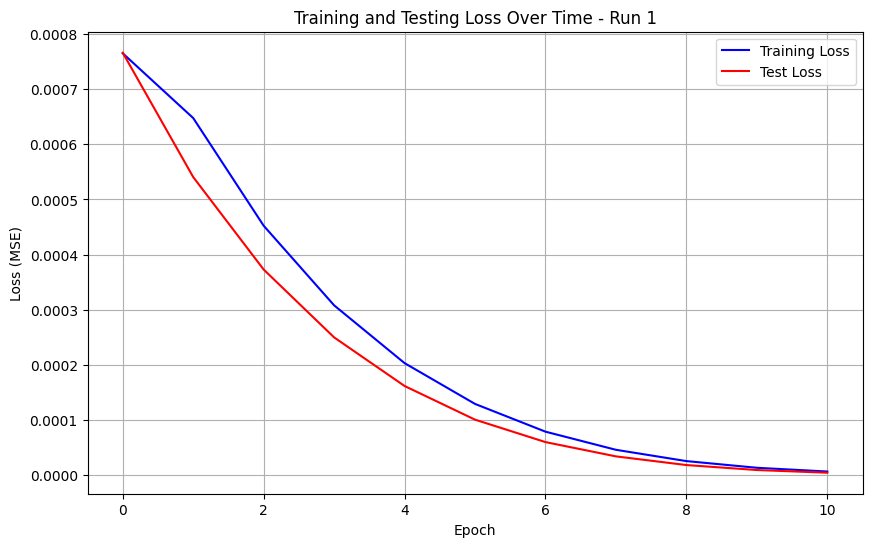

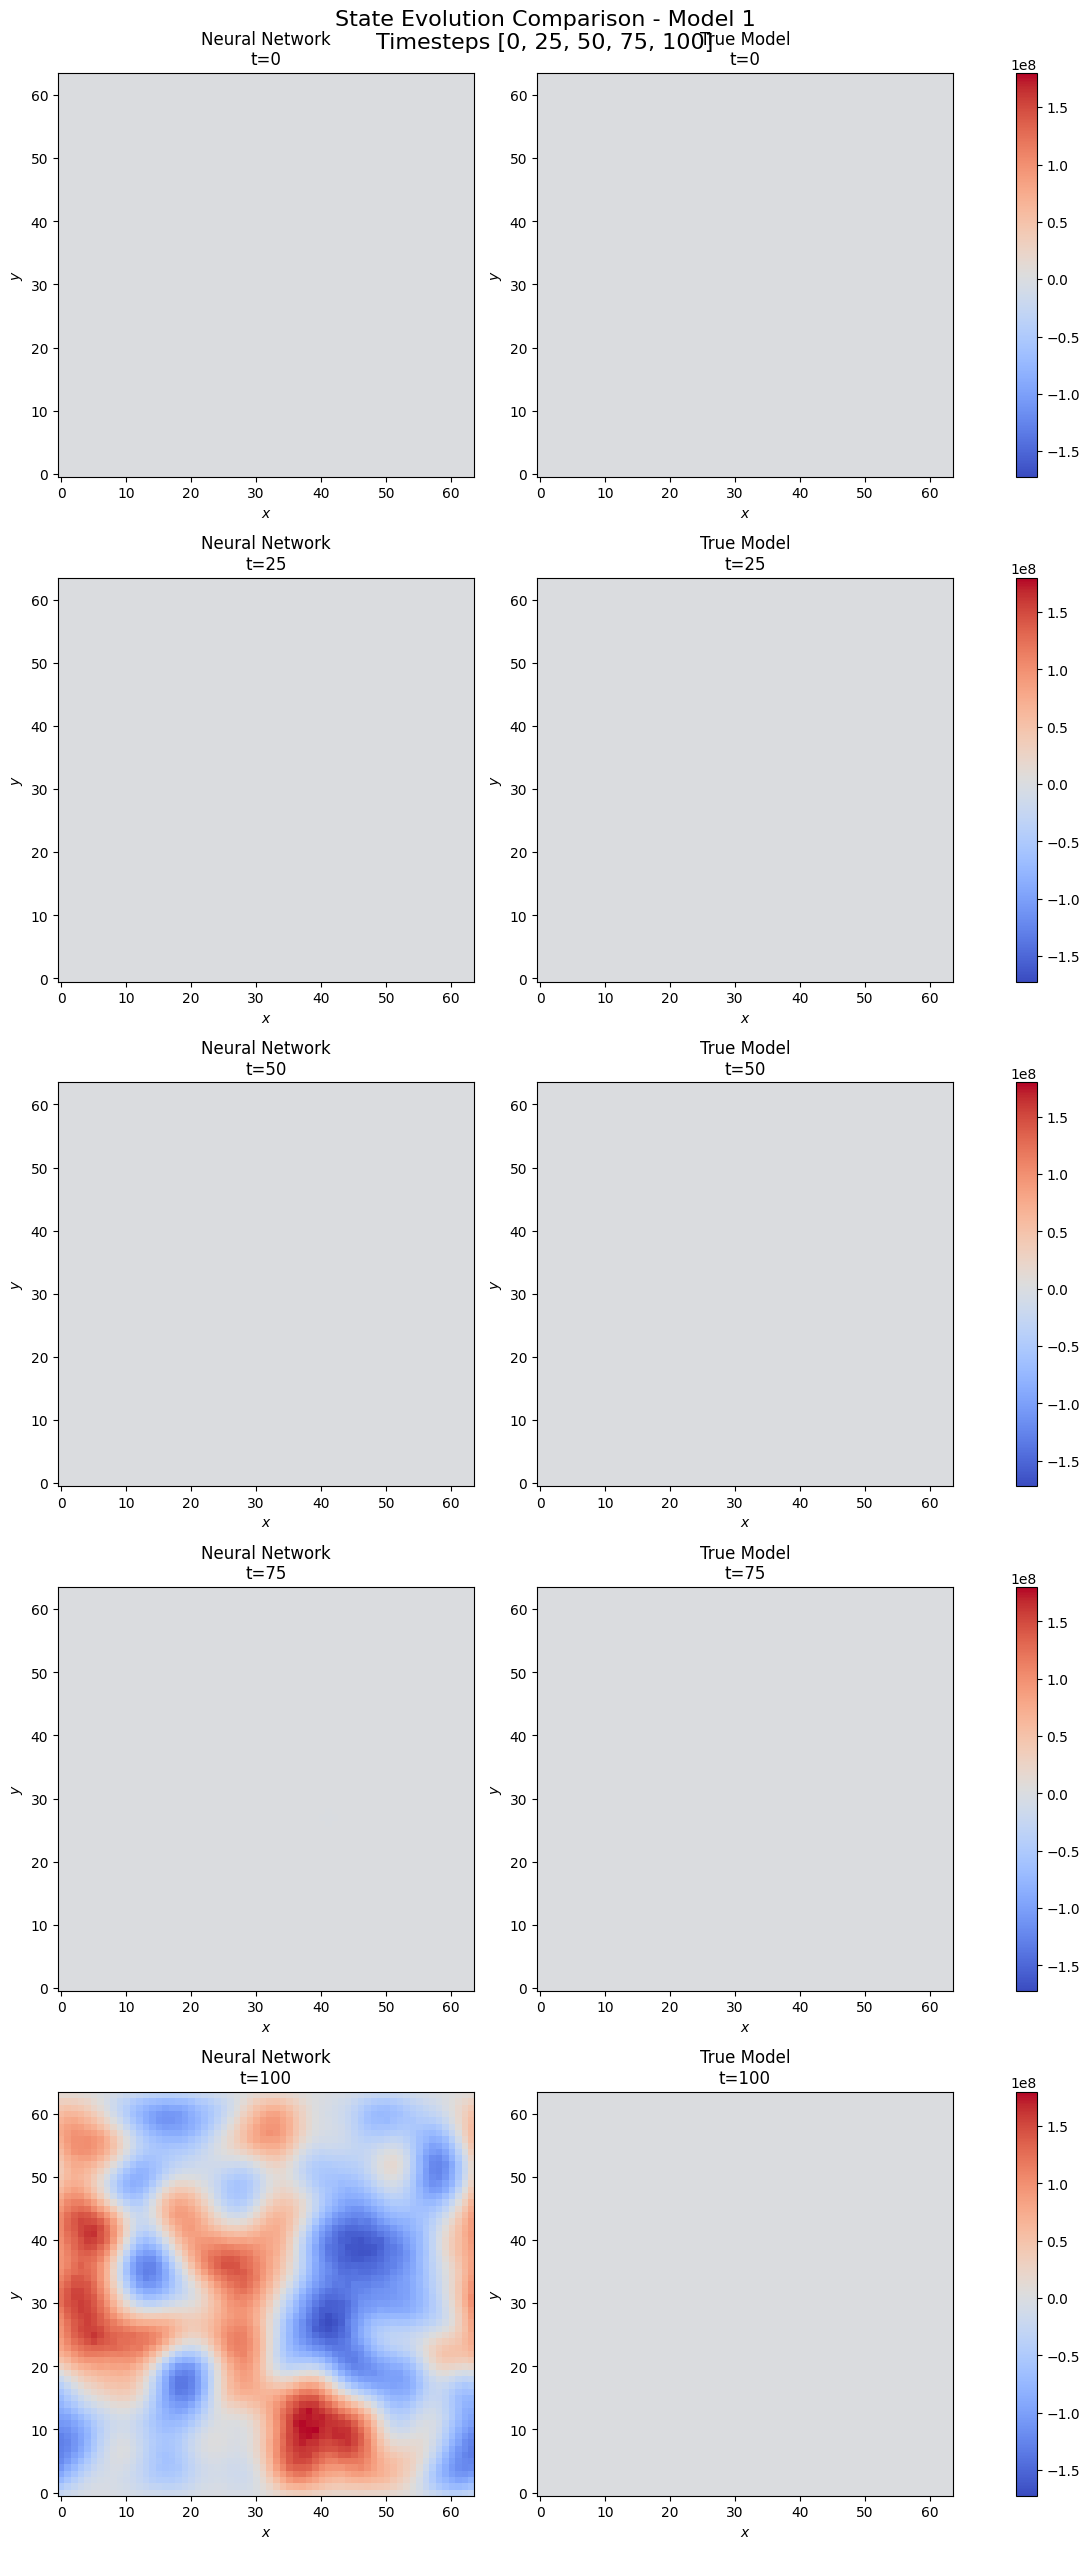

In [31]:

# Train multiple models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
models, train_losses, test_losses = train_multiple_models(
    nr=nr,
    nc=nc,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    train_data=train_data,  # Pass in the train_data dictionary
    num_runs=1,
    num_epochs=10,
    device=device,
    num_timesteps_sim=100
)



- How much smaller can we make it? - Vince

Previous problems: 
* Accidentally created different model for testing and training
* Parameters were too big, caused nasty divergence (heat temps exploding way too high)

Comments:
- Simplest linear model is perfect
- Other models not so much
- ReLU vs Linear hidden layer not super different
- Smallest network is worse, as expected
- No longer varies much between initializations

# Compare learned network to M

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

def extract_linear_params(model: torch.nn.Module) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract the weight matrix A and bias vector b from a linear neural network.
    
    Args:
        model: PyTorch model with a single linear layer
        
    Returns:
        Tuple containing:
        - A: Weight matrix as numpy array
        - b: Bias vector as numpy array
    """
    # Get the first (and only) linear layer
    linear_layer = model.fc1
    
    # Extract weights and biases
    A = linear_layer.weight.detach().cpu().numpy()
    b = linear_layer.bias.detach().cpu().numpy() if linear_layer.bias is not None else np.zeros(A.shape[0])
    
    return A, b

def compare_matrices(A: np.ndarray, M: np.ndarray, b: np.ndarray, 
                    f: Optional[np.ndarray] = None, F: Optional[float] = None) -> dict:
    """
    Compare the learned matrix A with the true matrix M and analyze differences.
    
    Args:
        A: Weight matrix from neural network
        M: True model matrix
        b: Bias vector from neural network
        f: Optional forcing field
        F: Optional forcing parameter
        
    Returns:
        Dictionary containing comparison metrics
    """
    # Calculate basic matrix differences
    diff = A - M
    rel_diff = np.abs(diff) / (np.abs(M) + 1e-10)  # Add small epsilon to avoid division by zero
    #Mask relative differences for values that are 0 in M: check M
    rel_diff[np.abs(M) < 1e-10] = 0

    # Create masks for off-diagonal elements
    mask = ~np.eye(M.shape[0], dtype=bool)
    
    # Get off-diagonal elements only
    diff_no_diag = diff[mask]
    M_no_diag = M[mask]
    A_no_diag = A[mask]
    
    # Compare bias with forcing term if provided
    if f is not None and F is not None:
        forcing_term = F * f
        bias_diff = b - forcing_term
        bias_rel_diff = np.abs(bias_diff) / (np.abs(forcing_term) + 1e-10)
    else:
        bias_diff = None
        bias_rel_diff = None
    
    # Calculate various metrics
    metrics = {
        'max_abs_diff': np.max(np.abs(diff)),
        'magn(M)': np.linalg.norm(M),
        'magn(M_no_diag)': np.linalg.norm(M_no_diag),
        'magn(A)': np.linalg.norm(A),
        'magn(A_no_diag)': np.linalg.norm(A_no_diag),
        'magn(diff)/magn(M)': np.linalg.norm(diff) / np.linalg.norm(M),
        'magn(diff_no_diag)/magn(M_no_diag)': np.linalg.norm(diff_no_diag) / np.linalg.norm(M_no_diag),
        'normalized dot product': np.dot(A.flatten(), M.flatten()) / (np.linalg.norm(A) * np.linalg.norm(M)),
        'no-diag normalized dot product': np.dot(A_no_diag, M_no_diag) / (np.linalg.norm(A_no_diag) * np.linalg.norm(M_no_diag))
    }
    
    if bias_diff is not None:
        metrics.update({
            'bias_norm_diff': np.linalg.norm(bias_diff),
            'relative_bias_norm': np.linalg.norm(bias_diff) / np.linalg.norm(forcing_term),
            'max_abs_bias_diff': np.max(np.abs(bias_diff)),
            'mean_abs_bias_diff': np.mean(np.abs(bias_diff)),
            'mean_rel_bias_diff': np.mean(bias_rel_diff),
            'magnitude(bias_diff)/magnitude(forcing_term)': np.linalg.norm(bias_diff) / np.linalg.norm(forcing_term),
            'magn(bias)': np.linalg.norm(b),
        })
    
    return metrics

def visualize_comparison(A: np.ndarray, M: np.ndarray, b: np.ndarray, 
                        f: Optional[np.ndarray] = None, F: Optional[float] = None,
                        nr: int = None, nc: int = None) -> None:
    """
    Create visualizations comparing the matrices and bias terms.
    
    Args:
        A: Weight matrix from neural network
        M: True model matrix
        b: Bias vector from neural network
        f: Optional forcing field
        F: Optional forcing parameter
        nr: Number of rows in grid (for reshaping)
        nc: Number of columns in grid (for reshaping)
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Create masked versions of matrices
    A_masked = A.copy()
    M_masked = M.copy()
    mask = np.eye(M.shape[0], dtype=bool)
    A_masked[mask] = 0  # or use 0 instead of np.nan if preferred
    M_masked[mask] = 0  # or use 0 instead of np.nan if preferred


    # Plot matrices
    im1 = axes[0,0].imshow( A_masked)
    axes[0,0].set_title('Neural Network Matrix (A) with diagonal masked')
    plt.colorbar(im1, ax=axes[0,0])
    
    im2 = axes[0,1].imshow(M_masked)
    axes[0,1].set_title('True Model Matrix (M) with diagonal masked')
    plt.colorbar(im2, ax=axes[0,1])
    
    # Plot difference
    diff = A_masked - M_masked #A - M
    im3 = axes[1,0].imshow(diff)
    axes[1,0].set_title('Difference (A - M)')
    plt.colorbar(im3, ax=axes[1,0])
    
    # Plot bias comparison if forcing term available
    if f is not None and F is not None:
        forcing_term = F * f
        if nr is not None and nc is not None:
            # Reshape for 2D visualization if dimensions provided
            b_reshaped = b.reshape(nr, nc)
            forcing_reshaped = forcing_term.reshape(nr, nc)
            bias_diff = b_reshaped - forcing_reshaped
        else:
            bias_diff = b - forcing_term
            
        im4 = axes[1,1].imshow(bias_diff)
        axes[1,1].set_title('Bias - Forcing Term Difference')
        plt.colorbar(im4, ax=axes[1,1])
    else:
        if nr is not None and nc is not None:
            b_reshaped = b.reshape(nr, nc)
        else:
            b_reshaped = b
        im4 = axes[1,1].imshow(b_reshaped)
        axes[1,1].set_title('Bias Term')
        plt.colorbar(im4, ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()

def analyze_model(model: torch.nn.Module, M: np.ndarray, f: Optional[np.ndarray] = None, 
                 F: Optional[float] = None, nr: Optional[int] = None, nc: Optional[int] = None) -> None:
    """
    Complete analysis of a trained model compared to true system.
    
    Args:
        model: Trained PyTorch model
        M: True model matrix
        f: Optional forcing field
        F: Optional forcing parameter
        nr: Optional number of rows for reshaping
        nc: Optional number of columns for reshaping
    """
    # Extract parameters
    A, b = extract_linear_params(model)
    
    # Compare matrices
    metrics = compare_matrices(A, M, b, f, F)
    
    # Print metrics
    print("Comparison Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.6e}")
    
    # Visualize comparison
    visualize_comparison(A, M, b, f, F, nr, nc)
    
    return A, b, metrics

In [33]:
# Analyze the trained model from the final cell
if len(models) > 0:
    trained_model = models[0]  # Get first model since num_runs=1
    
    A, b, metrics = analyze_model(
        model=trained_model,
        M=M,  # The true model matrix 
        f=train_data['shared_params']['f'].numpy(),  # The forcing field
        F=train_data['metadata']['F'],  # The forcing parameter
        nr=train_data['metadata']['nr'],  # Number of rows
        nc=train_data['metadata']['nc']  # Number of columns
    )

else:
    print("No trained models found in the 'models' container.")


AttributeError: 'PrunedStateModelNet' object has no attribute 'fc1'

In [13]:
import torch

model = trained_model

# Use the first input-output pair from the test data: not the whole batch, just the first data point
sample_batch = next(iter(test_loader))
input_batch, output_batch = sample_batch

input_data = input_batch[0].unsqueeze(0)
output_data = output_batch[0].unsqueeze(0)



In [ ]:




def analyze_gradients(model, input_data, output_data, M, nr=None, nc=None):
    """
    Analyze the gradient matrix of the model.
    
    Args:
        model: PyTorch model
        input_data: Input tensor
        output_data: Target output tensor
        nr: Number of rows (for reshaping visualization)
        nc: Number of columns (for reshaping visualization)
    """
    # Compute Jacobian
    jacobian = torch.autograd.functional.jacobian(model, input_data)
    jacobian = jacobian.view(output_data.size(-1), input_data.size(-1))
    jacobian = jacobian.detach().numpy()
    
    # For a linear model, extract the weight matrix for comparison
    if not hasattr(model, 'fc2'):
        
        # Compute difference between Jacobian and weight matrix
        diff = jacobian - M
        max_diff = np.max(np.abs(diff))
        print(f"Maximum difference between Jacobian and weight matrix: {max_diff}")
        
        if max_diff < 1e-6:
            print("Gradient matrix is effectively identical to weight matrix (as expected for a linear model)")
        else:
            print("Warning: Gradient matrix differs from weight matrix - model may not be purely linear")
    
    # Visualize the gradient matrix
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(jacobian)
    plt.colorbar()
    plt.title('Gradient Matrix (Jacobian)')
    
    # If spatial dimensions are provided, show example input and output
    if nr is not None and nc is not None:
        plt.subplot(132)
        plt.imshow(input_data.detach().numpy().reshape(nr, nc))
        plt.colorbar()
        plt.title('Input State')
        
        plt.subplot(133)
        plt.imshow(output_data.detach().numpy().reshape(nr, nc))
        plt.colorbar()
        plt.title('Target Output State')
    
    plt.tight_layout()
    plt.show()
    
    return jacobian

# Example usage:
jacobian = analyze_gradients(model, input_data, output_data, M, nr=64, nc=64)